# ベイズ統計の枠組みと解釈について
- [オリジナルの URL: GitHub 上の ipynb へのリンク](https://github.com/genkuroki/Statistics/blob/master/Introduction%20to%20Bayesian%20Statistics.ipynb)

上記解析・式とプログラムが一体になっていて内容としては優れた ipynb だが、MathJax 変換で重いといった問題があった。
式・解説を手元で TeX 化しつつ、プログラム部分だけを外だしする形にした。

## ライブラリの読み込み

In [1]:
using Base64
displayfile(mime, file; tag="img") = open(file) do f
    display("text/html", """<$tag src="data:$mime;base64,$(base64encode(f))">""")
end

using Distributions
using Statistics
using StatsBase

using StatsPlots
using Plots
default(size=(400, 250), titlefontsize=10)
pyplot(fmt=:svg)
PyPlot_clf() = if backend() == Plots.PyPlotBackend() PyPlot.clf() end

using Random
using QuadGK
using SpecialFunctions

## 例：未知の母集団分布$q(x)$のサイズ$n=50$のサンプル
次のようなサンプルが得られたとする。

    1.1, 1.45, 0.93, 2.01, 0.13, 1.78, 1.07, 0.75, 0.48, 0.64,
    0.81, 1.13, 0.89, 1.39, 0.69, 0.57, 3.22, 1.18, 2.03, 0.85,
    1.08, 0.96, 1.1, 0.81, 1.19, 1.09, 1.51, 1.01, 0.54, 0.84,
    1.06, 0.33, 1.14, 0.67, 1.57, 0.88, 0.48, 0.78, 0.38, 0.82,
    0.53, 0.52, 1.18, 0.67, 2.01, 1.14, 0.71, 0.69, 1.24, 0.72

このサンプルのヒストグラムは以下の通り.

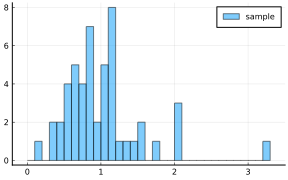

In [2]:
X = [1.1, 1.45, 0.93, 2.01, 0.13, 1.78, 1.07, 0.75, 0.48, 0.64, 0.81, 1.13, 0.89, 1.39, 0.69, 0.57, 3.22, 1.18, 2.03, 0.85, 1.08, 0.96, 1.1, 0.81, 1.19, 1.09, 1.51, 1.01, 0.54, 0.84, 1.06, 0.33, 1.14, 0.67, 1.57, 0.88, 0.48, 0.78, 0.38, 0.82, 0.53, 0.52, 1.18, 0.67, 2.01, 1.14, 0.71, 0.69, 1.24, 0.72]
histogram(X; bins=range(0, 3.3, step=0.1), alpha=0.5, label="sample")

実はこれはパラメーター$(\alpha,\theta)=(4, 1/4)$のガンマ分布を母集団分布とするサンプルをコンピューターの擬似乱数で生成したものである
(ただし小数点以下2桁までに丸めた).
その母集団分布の平均と分散はそれぞれ$1$と$0.25$で、
標準偏差は$0.5$である。

上のサンプルの平均と分散 (不偏分散ではなく単なる分散) はそれぞれ 1.015, 0.276 程度になる. 
上のヒストグラムを見ればこの母集団分布はそれらを平均と分散とする正規分布で近似されるのではないだろうかと思う人がいても不思議ではない。
上のヒストグラムとその正規分布を重ねてプロットしてみよう。

In [3]:
function fit_mle_and_plot(X, model, model_str; x = range(0, 3.3, length=200))
    dist_mle = fit_mle(model, X)
    f(x) = pdf(dist_mle, x)
    AIC = -2sum(logpdf.(dist_mle, X)) + 2length(params(dist_mle))
    histogram(X; bins=range(0, 3.3, step=0.1), alpha=0.5, ylim=(0, 1.7), label="sample", norm=true)
    plot!(x, pdf.(Gamma(4, 0.25), x), label="true population dist", lw=1.5, ls=:dash, color=:black)
    plot!(x, f.(x), label="$model_str dist approx", lw=2, color=:red)
    title!("$model_str dist model: AIC =$(round(AIC, digits=2))")
end

fit_mle_and_plot (generic function with 1 method)

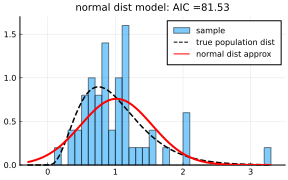

In [4]:
fit_mle_and_plot(X, Normal, "normal"; x = range(-0.3, 3.3, length=200))

別の人は「この分布は正値なので対数正規分布に違いない」と思うかもしれない.
その人は次のようなプロットを作成するだろう.

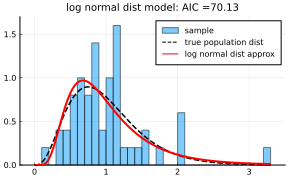

In [5]:
fit_mle_and_plot(X, LogNormal, "log normal"; x = range(0, 3.3, length=200))

対数正規分布だと思った人は正規分布だと思った人よりはずっと正確な予測分布を得ている.
しかし実際には真の母集団分布はガンマ分布である.
ある人が特別な神眼によって「これはガンマ分布だ！」と見抜いたとしよう. その人は次のようにプロットするだろう.

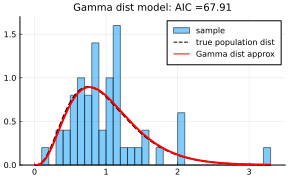

In [6]:
fit_mle_and_plot(X, Gamma, "Gamma"; x = range(0, 3.3, length=200))

さすが神眼！ 予測分布(赤線)と真の母集団分布(黒の点線)がぴったり一致している！(笑)
現実にはこのような神眼をはっきできることはまれであり, 真の母集団分布は名前が付けられていないわけのわからない分布かもしれない.
母集団分布$q(x)$が未知の状況でその有限サイズのサンプルが得られているとき、母集団分布を推測することは困難でかつ非常に面白い問題になっていることがよくある.

## 例: 正規分布モデルの尤度函数

### 尤度函数のプロット

 44.333766 seconds (11.74 M allocations: 543.179 MiB, 0.63% gc time)
  0.927897 seconds (147.79 k allocations: 7.461 MiB)


┌ Info: Saved animation to 
│   fn = C:\Users\4429s\codes\working\images\lik_normal_for_gamma_sample.gif
└ @ Plots C:\Users\4429s\.julia\packages\Plots\vsE7b\src\animation.jl:104



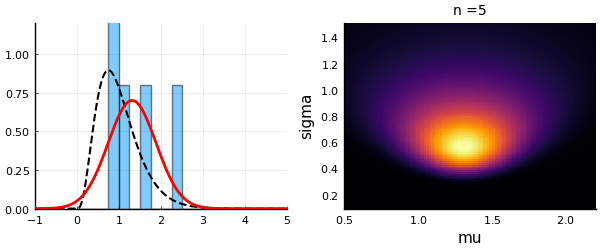

In [7]:
Random.seed!(37346491)

dist_gamma = Gamma(4.0, 0.25)
N = 200
XX = rand(dist_gamma, N)

ns = [5;5;5;5;5; 5:10; 12:2:20; 25:5:N; N;N;N;N;N]
@time anim = @animate for n in ns
    X = @view XX[1:n]
    x = range(-1, 5, length=200)

    dist_normal_approx_gamma = fit_mle(Normal, X)
    P1 = histogram(X; normed=true, bins=range(0, 5, step=0.25), alpha=0.5, label="sample")
    plot!(x, pdf.(dist_gamma, x); label="true dist", lw=1.5, ls=:dash, color=:black)
    plot!(x, pdf.(dist_normal_approx_gamma, x); label="normal approx", lw=2, color=:red)
    plot!(legend=false, xlim=(-1, 5), ylim=(0, 1.2))

    loglik(μ, σ) = sum(logpdf(Normal(μ, σ), x) for x in X)
    μ = range(0.5, 2.2, length=100)
    σ = range(0.1, 1.5, length=100)
    P2 = heatmap(μ, σ, exp.(loglik.(μ', σ)); xlabel="mu", ylabel="sigma",
        size=(300, 320), colorbar=false, title="n =$n")

    plot(P1, P2, size=(600, 250))
end
PyPlot_clf()
@time gif(anim, "images/lik_normal_for_gamma_sample.gif", fps=5)
sleep(0.1)
displayfile("image/gif", "images/lik_normal_for_gamma_sample.gif")

### 上の動画の観察
- 尤度函数のグラフは単峰型であり, その台のサイズはサンプルサイズを大きくすると小さくなり, 1点に収束して行く.
- 予測分布はモデルの分布の中でサンプルの母集団分布を最もよく予測するものに収束して行く.
- モデルの分布の中にサンプルの母集団分布をよく近似するものが含まれていなければ予測分布の誤差は大きくなる.

この観察は最尤法がうまく行くケースでは常に成り立っていると考えてよい.

### 詳しい説明
この動画ではガンマ分布
$$
q(x|\alpha,\theta) = \frac{1}{\theta^\alpha\Gamma(\alpha)}e^{-x/\theta}x^{\alpha-1}, \quad (x>0)
$$
の$(\alpha,\theta)=(4, 0.25)$の場合を母集団とするサイズ$n=5,6\ldots,300$のサンプル$X_1,\ldots,X_n$に関する正規分布モデル
$$
p(x|\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-(x-\mu)^2/(2\sigma^2)}
$$
の尤度函数
$$
(\mu, \sigma)\mapsto \prod_{k=1}^n p(X_k|\mu,\sigma)
$$
とこれを最大化する$(\mu,\sigma)=(\hat{\mu}, \hat{\sigma})$から作った予測分布$p(x|\hat{\mu},\hat{\sigma})$をプロットしている. 
動画の右半分が尤度函数のプロットであり, 左半分のヒストグラムはサンプルのプロット, 
黒の点線はサンプルを生成したガンマ分布のプロット, 赤線は予測分布である.
<img src="images/lik_normal_for_gamma_sample.gif">

## 例：ガンマ分布モデルの尤度函数
正規分布モデルではなく, 真の母集団分布を含むガンマ分布モデルの尤度函数をプロットしてみよう.

### 尤度函数のプロット

 63.131065 seconds (6.23 M allocations: 251.434 MiB, 0.21% gc time)
  0.800647 seconds (547 allocations: 101.391 KiB)


┌ Info: Saved animation to 
│   fn = C:\Users\4429s\codes\working\images\lik_gamma_for_gamma_sample.gif
└ @ Plots C:\Users\4429s\.julia\packages\Plots\vsE7b\src\animation.jl:104



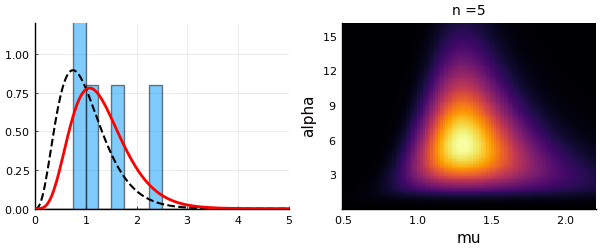

In [8]:
Random.seed!(37346491)

dist_gamma = Gamma(4.0, 0.25)
N = 200
XX = rand(dist_gamma, N)

ns = [5;5;5;5;5; 5:10; 12:2:20; 25:5:N; N;N;N;N;N]
@time anim = @animate for n in ns
    X = @view XX[1:n]
    x = range(0, 5, length=200)

    dist_gamma_approx_gamma = fit_mle(Gamma, X)
    P1 = histogram(X; normed=true, bins=range(0, 5, step=0.25), alpha=0.5, label="sample")
    plot!(x, pdf.(dist_gamma, x); label="true dist", lw=1.5, ls=:dash, color=:black)
    plot!(x, pdf.(dist_gamma_approx_gamma, x); label="Gamma approx", lw=2, color=:red)
    plot!(legend=false, xlim=(0, 5), ylim=(0, 1.2))

    loglik(μ, α) = sum(logpdf(Gamma(α, μ/α), x) for x in X)
    μ = range(0.5, 2.2, length=100)
    α = range(0.1, 16, length=100)
    P2 = heatmap(μ, α, exp.(loglik.(μ', α)); xlabel="mu", ylabel="alpha",
        size=(300, 320), colorbar=false, title="n =$n")

    plot(P1, P2, size=(600, 250))
end
PyPlot_clf()
@time gif(anim, "images/lik_gamma_for_gamma_sample.gif", fps=5)
sleep(0.1)
displayfile("image/gif", "images/lik_gamma_for_gamma_sample.gif")

### 動画確認
確かに赤線の予測分布が黒の点線の真の母集団分布に近付いて行っているように見える.